In [1]:
# ----------------------------------------------------------------------------
# Author        :    Vasileios Perifanis
# Affiliation   :    Euclid team, Democritus University of Thrace, Dept. of Electrical & Computer Engineering
# Created Date  :    03/2022
# version       :    1.0
# ---------------------------------------------------------------------------

In [2]:
import numpy as np # linear algebra
import pandas as pd # data analysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("datasets/titanic_train.csv", header=0) # read csv

data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #extract the Salutations

# Assigning the NaN Values the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

data['Embarked'].fillna('S',inplace=True)

data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4

data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

data['Fare_Range']=pd.qcut(data['Fare'],5)
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

data.drop(['Name','Age','Ticket','Fare','Cabin','Initial','Fare_Range','PassengerId'],axis=1,inplace=True)

data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Family_Size,Alone,Fare_cat
0,0,3,0,1,0,0,1,1,0,0
1,1,1,1,1,0,1,2,1,0,3
2,1,3,1,0,0,0,1,0,1,1
3,1,1,1,1,0,0,2,1,0,3
4,0,3,0,0,0,0,2,0,1,1


In [4]:
def train_sk(train_X, train_Y, test_X, test_Y):
    # initialize classifier
    classifier = MLPClassifier(hidden_layer_sizes=(32,32,32), random_state=0, max_iter=500)

    # train the classifier
    classifier.fit(train_X,train_Y)

    # make predictions on train/test set
    y_pred_train = classifier.predict(train_X)
    y_pred = classifier.predict(test_X)

    # calculate scores
    accuracy_train = accuracy_score(y_pred_train, train_Y)
    precision_train = precision_score(y_pred_train, train_Y)
    recall_train = recall_score(y_pred_train, train_Y)
    f1_train = f1_score(y_pred_train, train_Y)

    accuracy = accuracy_score(y_pred, test_Y)
    precision = precision_score(y_pred, test_Y)
    recall = recall_score(y_pred, test_Y)
    f1 = f1_score(y_pred, test_Y)

    print(f"[Training set] Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}\n",
          f"[Testing set] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    return accuracy, precision, recall, f1

In [5]:
def split(data):
    train,test=train_test_split(data,test_size=0.2,random_state=0,stratify=data['Survived'])
    train_X=train[train.columns[1:]].to_numpy()
    train_Y=train[train.columns[:1]].to_numpy().ravel()
    test_X=test[test.columns[1:]].to_numpy()
    test_Y=test[test.columns[:1]].to_numpy().ravel()
    return train_X, train_Y, test_X, test_Y

In [6]:
accuracy, precision, recall, f1 = dict(), dict(), dict(), dict()

In [7]:
from sklearn import preprocessing

In [8]:
train_X, train_Y, test_X, test_Y = split(data)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)

In [9]:
acc, prec, rec, f = train_sk(train_X, train_Y, test_X, test_Y)
accuracy['baseline'] = acc
precision['baseline'] = prec
recall['baseline'] = rec
f1['baseline'] = f

[Training set] Accuracy: 0.8820, Precision: 0.8388, Recall: 0.8513, F1: 0.8450
 [Testing set] Accuracy: 0.7933, Precision: 0.6522, Recall: 0.7759, F1: 0.7087


In [10]:
train_X.shape

(712, 9)

# K-Best

Selects the top-k features based on statistical tests, e.g. chi2, ANOVA, mutual information.

In [11]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

train_X, train_Y, test_X, test_Y = split(data)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
X_train_new = SelectKBest(chi2, k=7).fit_transform(train_X, train_Y)
X_test_new = SelectKBest(chi2, k=7).fit_transform(test_X, test_Y)

acc, prec, rec, f = train_sk(X_train_new, train_Y, X_test_new, test_Y)
accuracy['kbest_x2'] = acc
precision['kbest_x2'] = prec
recall['kbest_x2'] = rec
f1['kbest_x2'] = f

[Training set] Accuracy: 0.8553, Precision: 0.7692, Recall: 0.8400, F1: 0.8031
 [Testing set] Accuracy: 0.7821, Precision: 0.5942, Recall: 0.7885, F1: 0.6777


In [12]:
train_X, train_Y, test_X, test_Y = split(data)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
X_train_new = SelectKBest(f_classif, k=7).fit_transform(train_X, train_Y)
X_test_new = SelectKBest(f_classif, k=7).fit_transform(test_X, test_Y)

acc, prec, rec, f = train_sk(X_train_new, train_Y, X_test_new, test_Y)
accuracy['kbest_fclassif'] = acc
precision['kbest_fclassif'] = prec
recall['kbest_fclassif'] = rec
f1['kbest_fclassif'] = f

[Training set] Accuracy: 0.8553, Precision: 0.7692, Recall: 0.8400, F1: 0.8031
 [Testing set] Accuracy: 0.8045, Precision: 0.6377, Recall: 0.8148, F1: 0.7154


In [13]:
train_X, train_Y, test_X, test_Y = split(data)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
X_train_new = SelectKBest(mutual_info_classif, k=7).fit_transform(train_X, train_Y)
X_test_new = SelectKBest(mutual_info_classif, k=7).fit_transform(test_X, test_Y)

acc, prec, rec, f = train_sk(X_train_new, train_Y, X_test_new, test_Y)
accuracy['kbest_mutual_info'] = acc
precision['kbest_mutual_info'] = prec
recall['kbest_mutual_info'] = rec
f1['kbest_mutual_info'] = f

[Training set] Accuracy: 0.8596, Precision: 0.7399, Recall: 0.8745, F1: 0.8016
 [Testing set] Accuracy: 0.7542, Precision: 0.5942, Recall: 0.7193, F1: 0.6508


# Recursive Feature Elimination

Selects features by iteratively selecting a sub-sample. First, it trains a model on the whole dataset. Then, the less important features are eliminated.

In [14]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)
selector = RFE(estimator, n_features_to_select=7, step=1)

train_X, train_Y, test_X, test_Y = split(data)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
X_train_new = selector.fit_transform(train_X, train_Y)
X_test_new = selector.fit_transform(test_X, test_Y)

acc, prec, rec, f = train_sk(X_train_new, train_Y, X_test_new, test_Y)
accuracy['RFE'] = acc
precision['RFE'] = prec
recall['RFE'] = rec
f1['RFE'] = f

[Training set] Accuracy: 0.8624, Precision: 0.7436, Recall: 0.8788, F1: 0.8056
 [Testing set] Accuracy: 0.7765, Precision: 0.5652, Recall: 0.7959, F1: 0.6610


# Sequential Feature Selection

In [15]:
from sklearn.feature_selection import SequentialFeatureSelector

estimator = RandomForestClassifier(n_estimators=100)
sfs = SequentialFeatureSelector(estimator, n_features_to_select=7)

train_X, train_Y, test_X, test_Y = split(data)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)
X_train_new = sfs.fit_transform(train_X, train_Y)
X_test_new = sfs.fit_transform(test_X, test_Y)

acc, prec, rec, f = train_sk(X_train_new, train_Y, X_test_new, test_Y)
accuracy['SFS'] = acc
precision['SFS'] = prec
recall['SFS'] = rec
f1['SFS'] = f

[Training set] Accuracy: 0.8483, Precision: 0.7766, Recall: 0.8185, F1: 0.7970
 [Testing set] Accuracy: 0.4693, Precision: 0.3043, Recall: 0.3088, F1: 0.3066


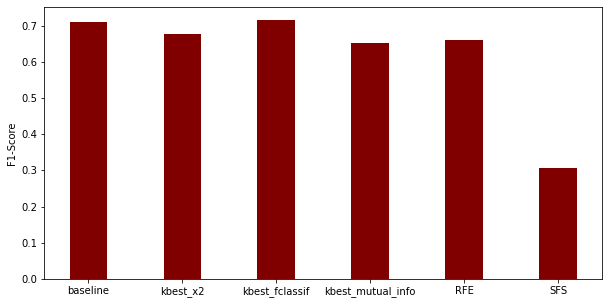

In [16]:
import matplotlib.pyplot as plt

scalers = list(f1.keys())
f_scores = list(f1.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(scalers, f_scores, color ='maroon',
        width = 0.4)
 
plt.xlabel("")
plt.ylabel("F1-Score")
plt.show()

In [17]:
accuracy, precision, recall, f1

({'baseline': 0.7932960893854749,
  'kbest_x2': 0.7821229050279329,
  'kbest_fclassif': 0.8044692737430168,
  'kbest_mutual_info': 0.7541899441340782,
  'RFE': 0.776536312849162,
  'SFS': 0.4692737430167598},
 {'baseline': 0.6521739130434783,
  'kbest_x2': 0.5942028985507246,
  'kbest_fclassif': 0.6376811594202898,
  'kbest_mutual_info': 0.5942028985507246,
  'RFE': 0.5652173913043478,
  'SFS': 0.30434782608695654},
 {'baseline': 0.7758620689655172,
  'kbest_x2': 0.7884615384615384,
  'kbest_fclassif': 0.8148148148148148,
  'kbest_mutual_info': 0.7192982456140351,
  'RFE': 0.7959183673469388,
  'SFS': 0.3088235294117647},
 {'baseline': 0.7086614173228347,
  'kbest_x2': 0.6776859504132232,
  'kbest_fclassif': 0.7154471544715448,
  'kbest_mutual_info': 0.6507936507936508,
  'RFE': 0.6610169491525423,
  'SFS': 0.30656934306569344})